# 5.3.2 例題 : Kaggleコンテスト「ダークマターの観測」

In [1]:
using Distributed
addprocs(3)

@everywhere using Mamba

In [2]:
using CSV
using DataFrames
using HTTP
using Plots
using LinearAlgebra

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


In [3]:
r = HTTP.request("GET", "https://git.io/vXLqk");
data = CSV.read(IOBuffer(r.body))
disallowmissing!(data)
first(data, 5)

5×5 DataFrame
│ Row │ GalaxyID │ x       │ y       │ e1       │ e2        │
│     │ String   │ Float64 │ Float64 │ Float64  │ Float64   │
├─────┼──────────┼─────────┼─────────┼──────────┼───────────┤
│ 1   │ Galaxy1  │ 162.69  │ 1600.06 │ 0.114664 │ -0.190326 │
│ 2   │ Galaxy2  │ 2272.28 │ 540.04  │ 0.623555 │ 0.214979  │
│ 3   │ Galaxy3  │ 3553.64 │ 2697.71 │ 0.283527 │ -0.30187  │
│ 4   │ Galaxy4  │ 1366.51 │ 4110.3  │ 0.36262  │ -0.000568 │
│ 5   │ Galaxy5  │ 4098.39 │ 3414.02 │ -0.43913 │ -0.019221 │

In [4]:
galaxy_position = [data[:x] data[:y]]

578×2 Array{Float64,2}:
  162.69  1600.06
 2272.28   540.04
 3553.64  2697.71
 1366.51  4110.3 
 4098.39  3414.02
 3649.23  3852.94
 1926.03  3097.5 
 3677.65  3000.52
  691.78  4199.06
 2246.89   515.27
 3744.75   940.71
  994.92  4003.35
 2060.3   1319.93
    ⋮            
 3597.27  1685.19
 2433.34  1901.4 
 1378.93  1307.07
 2796.16  2626.98
 1120.02   150.78
 1989.26  3311.57
  487.39  2381.64
 3576.68  2670.2 
  529.32  2188.21
  264.31  4083.7 
 2041.51    27.47
  840.08   532.86

In [5]:
ellpty = [data[:e1] data[:e2]]

578×2 Array{Float64,2}:
  0.114664  -0.190326
  0.623555   0.214979
  0.283527  -0.30187 
  0.36262   -0.000568
 -0.43913   -0.019221
 -0.137081   0.070594
  0.012969   0.258085
  0.072448  -0.173611
  0.154846   0.08308 
  0.559024   0.006138
 -0.136016   0.122976
  0.22694   -0.135647
 -0.429135   0.050928
  ⋮                  
 -0.321566  -0.017269
  0.08319   -0.483621
 -0.192827   0.127714
 -0.288615  -0.104543
  0.013106  -0.03046 
  0.126541   0.272779
  0.128308   0.199721
 -0.304011  -0.087968
 -0.419513   0.295542
 -0.054652  -0.132625
  0.183054  -0.399102
 -0.121471  -0.368851

## 可視化

In [6]:
function draw_sky(gxy_pos, ellpty, scale = 20)
    d = sqrt.(sum(ellpty .^ 2, dims = 2))
    a = 1 ./ (1 .- d)
    b = 1 ./ (1 .+ d)
    theta = vec(atan.(ellpty[:, 2], ellpty[:, 1]) * 0.5)
    
    plt = Plots.plot(size = (800, 800))
    for i in 1:size(gxy_pos, 1)
        theta_i = theta[i]
        rot = [cos(theta_i) -sin(theta_i); sin(theta_i) cos(theta_i)]
        xy = hcat([scale * rot * [a[i] * cos(t), b[i]* sin(t)] + gxy_pos[i, :] for t=0:pi/18:2pi]...)
        Plots.plot!(xy[1,:], xy[2,:], label = "", linewidth = 0, fillalpha = 0.8, fill=(0, :blue))
    end
    plt
end

draw_sky (generic function with 2 methods)

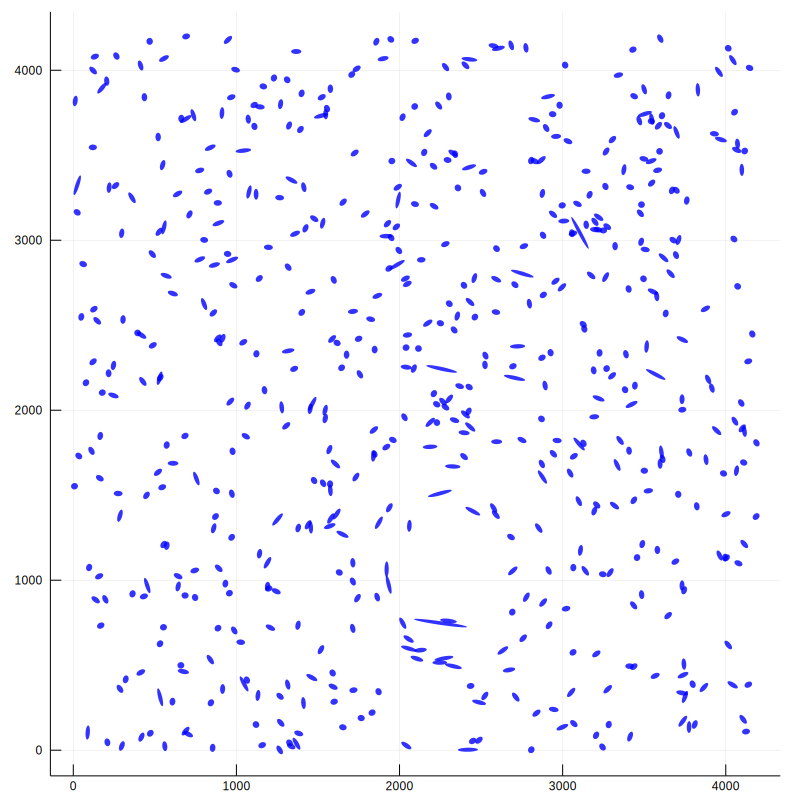

In [7]:
draw_sky(galaxy_position, ellpty)

## サンプルデータの作成

In [8]:
N = 500
mass_large = rand(Uniform(40, 180))
h_pos_sample = rand(Uniform(0, 4200), 2)
gxy_pos_sample = rand(Uniform(0, 4200), (N ,2));

In [9]:
@everywhere extensions = quote

    function f_distance(glx_pos, h_pos, c)
        euclidean_distance = sqrt(sum((glx_pos - h_pos) .^ 2))
        max(euclidean_distance, c)
    end

    function tangential_distance(glx_pos, h_pos)
        delta = glx_pos - h_pos
        t = 2 * atan(delta[2], delta[1])
        [-cos(t), -sin(t)]
    end

    function ellpty_mean_sample(x)
        mass_large / f_distance(x, h_pos_sample, 240) * tangential_distance(x, h_pos_sample)
    end

end

@everywhere eval(extensions)

In [10]:
ellpty_mean_sample_ = mapslices(ellpty_mean_sample, gxy_pos_sample, dims = 2)
ellpty_sample = permutedims(hcat(rand.(MultivariateDistribution[MvNormal(ellpty_mean_sample_[i, :], 0.2) for i in 1:N])...))

500×2 Array{Float64,2}:
 -0.188336    0.00322573
  0.376998   -0.17223   
 -0.545138   -0.292486  
 -0.119174   -0.365146  
 -0.261997    0.259577  
 -0.198179   -0.115003  
 -0.416636   -0.273239  
  0.0122934  -0.00264224
 -0.441997   -0.157385  
  0.464429   -0.0853787 
  0.0644976  -0.011128  
 -0.202027   -0.222296  
  0.265235    0.312583  
  ⋮                     
  0.272339    0.0979704 
  0.27106     0.302757  
 -0.0264212   0.138655  
 -0.182717   -0.0419471 
  0.215304   -0.226453  
 -0.172631   -0.300398  
 -0.0119319   0.122986  
 -0.0524309  -0.0856806 
 -0.241385    0.148023  
  0.323814    0.254293  
  0.0199542  -0.032424  
 -0.0651275  -0.0490794 

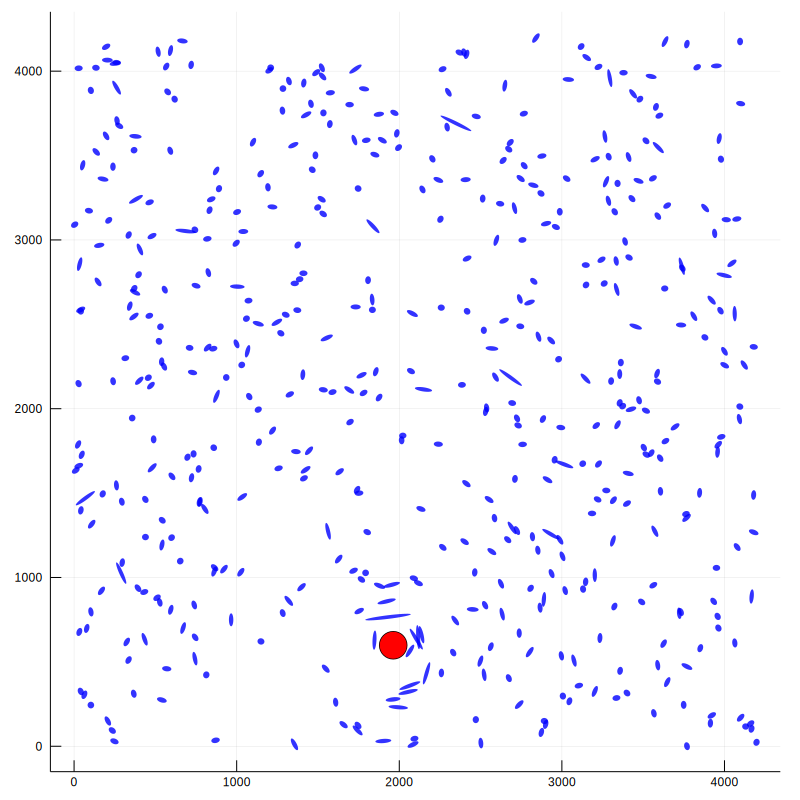

In [63]:
draw_sky(gxy_pos_sample, ellpty_sample)
scatter!(tuple(h_pos_sample...), markersize = 15, markercolor = :red, label = "")

## モデルの作成

In [33]:
model = Model(
    mass_large = Stochastic(() -> Uniform(40, 180)),
    halo_position = Stochastic(1, () -> Uniform(0, 4200)),
    mean = Logical(2, 
            (mass_large, galaxy_position, halo_position) -> 
            mapslices(x -> 
                mass_large / f_distance(x, halo_position, 240) * tangential_distance(x, halo_position), 
                galaxy_position, 
                dims = 2)
    ),
    ellpty = Stochastic(2, 
            (N, mean) -> 
            MultivariateDistribution[MvNormal(mean[i, :], 0.2) for i in 1:N], 
    false),
)

Object of type "Model"
-------------------------------------------------------------------------------
mean:
A monitored node of type "0×0 ArrayLogical{2}"
Array{Float64}(0,0)
-------------------------------------------------------------------------------
halo_position:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
mass_large:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
ellpty:
An unmonitored node of type "0×0 ArrayStochastic{2}"
Array{Float64}(0,0)


In [13]:
halo_data = Dict(
    :N => size(data, 1),
    :galaxy_position => galaxy_position,
    :ellpty => ellpty,
)

Dict{Symbol,Any} with 3 entries:
  :N               => 578
  :ellpty          => [0.114664 -0.190326; 0.623555 0.214979; … ; 0.183054 -0.3…
  :galaxy_position => [162.69 1600.06; 2272.28 540.04; … ; 2041.51 27.47; 840.0…

In [14]:
inits = [
    Dict(
        :mass_large => rand(Uniform(40, 180)),
        :halo_position => rand(Uniform(0, 4200), 2),
        :mean => fill(0, halo_data[:N]),
        :ellpty => halo_data[:ellpty],
    )
    for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:mean=>[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0],:halo_position=>[2811.78, 309.504],:mass_large=>56.1814,:ellpty=>[0.114664 -0.190326; 0.623555 0.214979; … ; 0.183054 -0.399102; -0.121471 -0.368851])
 Dict(:mean=>[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0],:halo_position=>[2683.96, 1493.31],:mass_large=>72.5077,:ellpty=>[0.114664 -0.190326; 0.623555 0.214979; … ; 0.183054 -0.399102; -0.121471 -0.368851])
 Dict(:mean=>[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0],:halo_position=>[2257.26, 2781.35],:mass_large=>119.359,:ellpty=>[0.114664 -0.190326; 0.623555 0.214979; … ; 0.183054 -0.399102; -0.121471 -0.368851])

In [39]:
scheme = [AMWG([:mass_large, :halo_position], 10)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:mass_large, :halo_position]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 10), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 10), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [45]:
setsamplers!(model, scheme)
sim = mcmc(model, halo_data, inits, 25000, burnin = 5000, thin = 5, chains = 3)

MCMC Simulation of 25000 Iterations x 3 Chains...

      From worker 4:	Chain 2:   0% [0:04:32 of 0:04:32 remaining]
      From worker 2:	Chain 1:   0% [0:04:41 of 0:04:41 remaining]
      From worker 3:	Chain 3:   0% [0:04:52 of 0:04:52 remaining]
      From worker 2:	Chain 1:  10% [0:04:50 of 0:05:23 remaining]
      From worker 4:	Chain 2:  10% [0:04:56 of 0:05:29 remaining]
      From worker 3:	Chain 3:  10% [0:05:00 of 0:05:34 remaining]
      From worker 2:	Chain 1:  20% [0:04:18 of 0:05:22 remaining]
      From worker 4:	Chain 2:  20% [0:04:21 of 0:05:27 remaining]
      From worker 3:	Chain 3:  20% [0:04:24 of 0:05:29 remaining]
      From worker 2:	Chain 1:  30% [0:03:43 of 0:05:18 remaining]
      From worker 4:	Chain 2:  30% [0:03:46 of 0:05:23 remaining]
      From worker 3:	Chain 3:  30% [0:03:47 of 0:05:25 remaining]
      From worker 2:	Chain 1:  40% [0:03:18 of 0:05:30 remaining]
      From worker 4:	Chain 2:  40% [0:03:21 of 0:05:35 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 5005:25000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 4000

[2332.97 1112.44 … -0.070993 -0.0670609; 2332.97 1112.44 … -0.0590105 -0.0557421; … ; 2319.53 1134.34 … -0.0593035 -0.0625786; 2277.83 1147.06 … -0.0432485 -0.0565877]

[2316.72 1085.61 … -0.0650967 -0.060838; 2316.72 1085.61 … -0.0643165 -0.0601089; … ; 2299.84 1076.03 … -0.06884 -0.0671638; 2340.3 1166.8 … -0.0668762 -0.0706712]

[2322.55 1121.0 … -0.0635175 -0.0639355; 2322.55 1121.0 … -0.0635175 -0.0639355; … ; 2303.54 1130.83 … -0.0599873 -0.067023; 2326.61 1121.61 … -0.0617038 -0.0612233]

In [46]:
describe(sim[:, [:mass_large, :halo_position], :])

Iterations = 5005:25000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 4000

Empirical Posterior Estimates:
                    Mean        SD     Naive SE     MCSE       ESS   
      mass_large  145.49677 10.246395 0.09353636 0.21926953 2183.6628
halo_position[1] 2324.55436 21.602343 0.19720151 0.56327826 1470.8072
halo_position[2] 1123.36389 37.765763 0.34475267 0.84137225 2014.7453

Quantiles:
                    2.5%       25.0%      50.0%      75.0%      97.5%  
      mass_large  125.42456  138.55647  145.42553  152.34537  166.06362
halo_position[1] 2281.17729 2309.75082 2325.17577 2339.17702 2366.14230
halo_position[2] 1049.53846 1098.63289 1123.23885 1148.56453 1195.43266



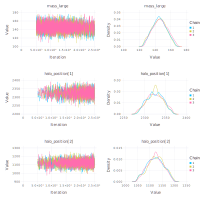

In [47]:
p = Mamba.plot(sim[:, [:mass_large, :halo_position], :], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

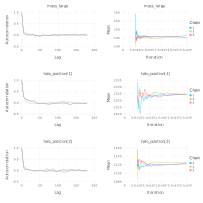

In [48]:
p = Mamba.plot(sim[:, [:mass_large, :halo_position], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

In [65]:
draw_sky(galaxy_position, ellpty)
scatter!(sim[:, :halo_position, :].value[:, 1, :][:],
        sim[:, :halo_position, :].value[:, 2, :][:],
        markerstrokewidth = 0,
        markercolor = :red, markeralpha = 0.015,
        label = "")